# Atmospheric composition distribution by CAMS and GOME-2

### Main goal:
* Compare GOME-2 and CAMS datasets for NO<sub>2</sub> (Level 3).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import wget # Important for GOME-2
import subprocess # Important for GOME-2
import geocoder
import seaborn as sns
from matplotlib.cbook import boxplot_stats
from matplotlib import animation
from IPython.display import HTML, display

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_gome.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
# Define component
component_nom = 'NO2'

# Define sensor
sensor = 'gome'
sensor_type = 'L3'
satellites = ['B']

# Define model
model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [5]:
# Define extent
lon_min = 60
lon_max = 150
lat_min = -10
lat_max = 55 

# Define resolution (Minimum: 0.25x.0.25)
lat_res = 0.25
lon_res = 0.25

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define search period
start_date = '2016-08-01'
end_date = '2016-08-31'
dates = search_period(start_date, end_date, sensor, sensor_type)

SEARCH PERIOD
- In months: ('2016-08',)


## 2. Model data

### Download and read data as xarray

In [6]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')

The file exists, it will not be downloaded again.


In [7]:
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 241, longitude: 480, time: 1)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2016-08-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -90.0 -89.25 -88.5 -87.75 ... 88.5 89.25 90.0
  * longitude   (longitude) float64 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
    valid_time  datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 3.459e-08 ... 4.112e-07
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-07T19:50 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [8]:
model_ds, units = model_convert_units(model_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Download and read data as xarray

In [9]:
sensor_product_names = sensor_download(sensor, sensor_type, component_nom)

File 'data/gome/NO2/monthly/2016-08/GOME_NO2_Global_201608_METOPB_DLR_v1.nc' already there; not retrieving.


In [10]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, component_nom, dates, sensor_column, satellites)
sensor_ds

<xarray.Dataset>
Dimensions:    (latitude: 1440, longitude: 1440, time: 1)
Coordinates:
  * latitude   (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time       (time) datetime64[ns] 2016-08-01
Data variables:
    NO2trop    (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    description:  Level 3 NO2 data
    Conventions:  CF-1.6

## 4. Match data

In [11]:
kernels_method = None
match_table = generate_match_table(sensor_ds, model_ds, bbox, kernels_method, 
                                   sensor, component_nom, sensor_column)
match_table

FOR MONTH: 2016-08
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.


,latitude,longitude,NO2trop,time,model_column
0,-10.125,59.875,3.077639e+14,2016-08-01,1.543205e+15
1,-10.125,60.125,3.021022e+14,2016-08-01,1.543205e+15
2,-10.125,60.375,3.373905e+14,2016-08-01,1.539547e+15
3,-10.125,60.625,5.623436e+14,2016-08-01,1.539547e+15
4,-10.125,60.875,6.691119e+14,2016-08-01,1.539547e+15
...,...,...,...,...,...
94216,54.875,148.875,5.362253e+14,2016-08-01,1.384959e+15
94217,54.875,149.125,6.664497e+14,2016-08-01,1.384959e+15
94218,54.875,149.375,1.061251e+15,2016-08-01,1.384959e+15
94219,54.875,149.625,1.188674e+15,2016-08-01,1.381885e+15


## 5. Merge data and calculate difference

In [12]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, kernels_method, sensor_column, sensor)
merge_table

NO2trop  model_column    difference
latitude longitude time                                                
-10.125  59.875    2016-08-01  3.077639e+14  1.543205e+15 -1.235441e+15
         60.125    2016-08-01  3.021022e+14  1.543205e+15 -1.241102e+15
         60.375    2016-08-01  3.373905e+14  1.539547e+15 -1.202157e+15
         60.625    2016-08-01  5.623436e+14  1.539547e+15 -9.772037e+14
         60.875    2016-08-01  6.691119e+14  1.539547e+15 -8.704353e+14
...                                     ...           ...           ...
 54.875  148.875   2016-08-01  5.362253e+14  1.384959e+15 -8.487333e+14
         149.125   2016-08-01  6.664497e+14  1.384959e+15 -7.185088e+14
         149.375   2016-08-01  1.061251e+15  1.384959e+15 -3.237079e+14
         149.625   2016-08-01  1.188674e+15  1.381885e+15 -1.932110e+14
         149.875   2016-08-01  1.209599e+15  1.381885e+15 -1.722862e+14

[94221 rows x 3 columns]

In [13]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,NO2trop,model_column,difference
count,9.228500e+04,9.422100e+04,9.228500e+04
mean,9.686177e+14,2.537222e+15,-1.552968e+15
std,9.663406e+14,1.894210e+15,1.439319e+15
min,1.851038e+11,1.083927e+15,-1.942149e+16
25%,5.121789e+14,1.551007e+15,-1.816870e+15
50%,7.450899e+14,1.967746e+15,-1.213485e+15
75%,1.106912e+15,2.610492e+15,-8.108110e+14
max,2.187172e+16,2.334765e+16,9.919790e+15


## 6. Show comparison plots

### Select plot dates

In [14]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2016-08']


### Select plot extent

In [15]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((60, -10), (150, 55))


### Compare CAMS and GOME-2 total columns

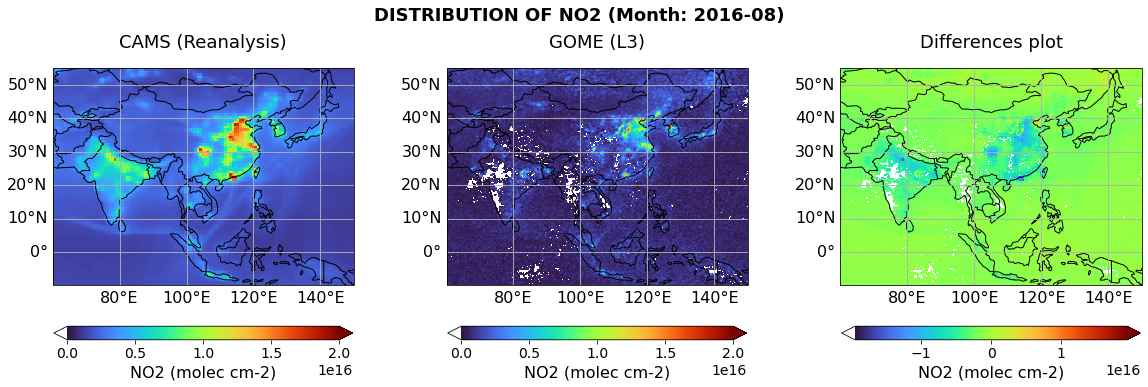

In [16]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'manual'
vmin_manual = 0
vmax_manual = 2*10**16

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'turbo'

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 1.05, 
                          model_type, sensor_type, range_type, sensor_column, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

In [17]:
coords_search_list = (50, 60,
                      4, 10,
                      20, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor_column, sensor, model, plot_dates, units)
retrieval_table_all

,,,,,NO2trop,model_column,difference
lat_search,lon_search,latitude,longitude,time,,,
50,60,49.875,59.875,2016-08-01,1.051269e+15,1.926880e+15,-8.756113e+14
4,10,3.875,59.875,2016-08-01,7.168895e+14,1.309877e+15,-5.929879e+14
20,30,19.875,59.875,2016-08-01,4.165145e+14,2.445562e+15,-2.029048e+15


## 8. Scatter plots by bbox

Fit equation: NO2_model = NO2_sensor * 1.31 + (1.25E+15)
Coefficient of determination (R2): 0.45


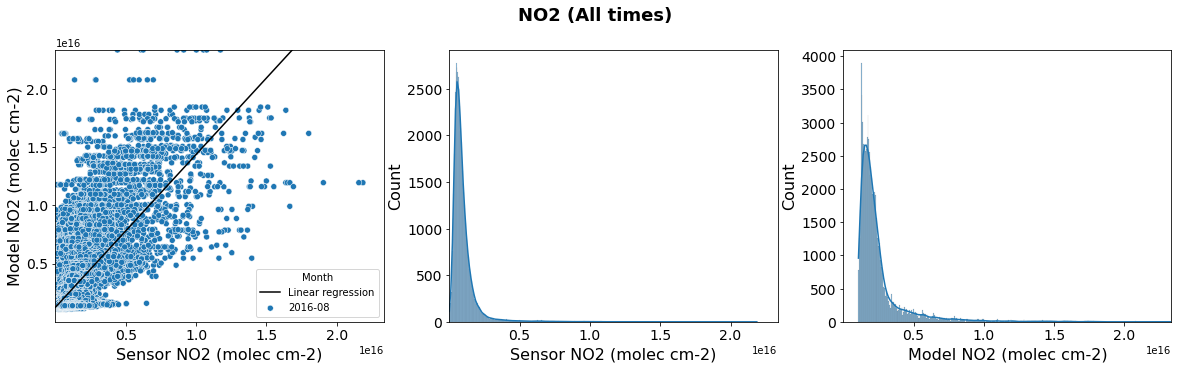

In [18]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [19]:
summary

,Period,Location,Score,Coefficient,Intercept
0,[2016-08-01T00:00:00.000000000],"((60, -10), (150, 55))",0.447992,1.312029,1.250731e+15


## 9. Scatter plots by season

Fit equation: NO2_model = NO2_sensor * 1.31 + (1.25E+15)
Coefficient of determination (R2): 0.45


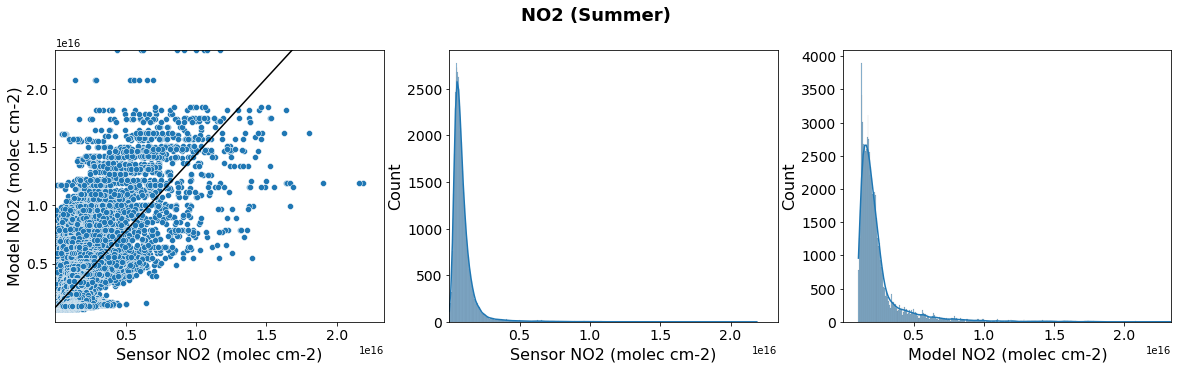

In [20]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [21]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Summer,"((60, -10), (150, 55))",0.447992,1.312029,1.250731e+15


## 10. Scatter plots by country (Google API required!)

In [22]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['France', 'Germany', 'Italy']
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['France', 'Germany', 'Italy']\nsummary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, \n                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_countries)\n"

In [23]:
#summary